This notebook is designed to analyze the result of denoising.

## Collect results from the filename.

In [20]:
from pathlib import Path
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns

In [33]:
MODELS=["unet","unetpp","pspnet","manet","linknet","fpn","deeplabv3p"]
ROOT=Path("/mnt/home/xiziyi/Packages_Research/deep_image_prior/figs_noise")

finder=re.compile("([\w\.]+?)\_step(\d+|inf)\_psnr(\d+\.\d+|inf)[\w\.]+")

data=defaultdict(lambda: defaultdict(dict))
for model in MODELS:
    cur=ROOT/model
    for each in cur.iterdir():
        name,step,psnr=finder.match(str(each.parts[-1])).groups()
        if step=="inf": continue
        if step=="0":
            data[model][name]["ref"]=float(psnr)
        if "psnr" not in data[model][name]:
            data[model][name]["psnr"]=np.zeros(8)
        pos=int(step)//200
        data[model][name]["psnr"][pos]=float(psnr)

# convert data into pandas
topandas={"keys":[]}
topandas_ref={"keys":[],"ref":[]}
for model in MODELS:
    topandas[model]=[]
for key in sorted(data["unet"].keys()):
    topandas["keys"].append(key)
    topandas_ref["keys"].append(key)
    topandas_ref["ref"].append(data["unet"][key]["ref"])
    for model in MODELS:
        topandas[model].append(max(data[model][key]["psnr"]))
df=pd.DataFrame.from_dict(topandas)
df_ref=pd.DataFrame.from_dict(topandas_ref)

## Now it's time to make some plot

firstly, we define val to monitor as psnr-ref, and plot all the curves 

/tmp/ipykernel_46181/565288626.py:1: FutureWarning: Dropping of nuisance columns in DataFrame.rank is deprecated; in a future version this will raise TypeError. Select only valid columns before calling rank.
  ax=sns.heatmap(df.rank(axis=1,ascending=False),cmap="rainbow")


Text(0.5, 1.0, 'Model Performance Rank (1 is the best)')

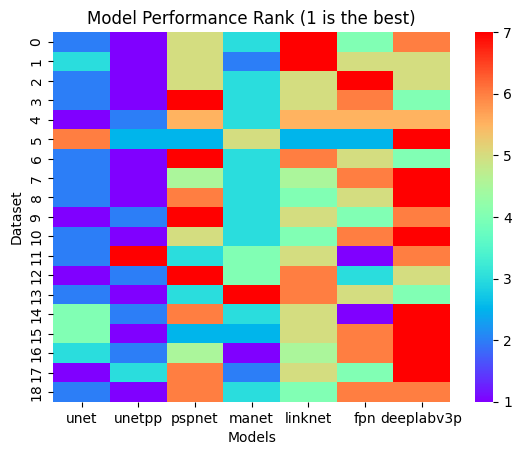

In [32]:
ax=sns.heatmap(df.rank(axis=1,ascending=False),cmap="rainbow")
ax.set_xlabel("Models")
ax.set_ylabel("Dataset")
ax.set_title("Model Performance Rank (1 is the best)")

for the 8 steps in training the model, we might want to calculate the diff with ref, and then calculate the errorbar along training for the 7 models.

In [65]:
MODELS=["unet","unetpp","pspnet","manet","linknet","fpn","deeplabv3p"]
ROOT=Path("/mnt/home/xiziyi/Packages_Research/deep_image_prior/figs_noise")

finder=re.compile("([\w\.]+?)\_step(\d+|inf)\_psnr(\d+\.\d+|inf)[\w\.]+")

df_step=pd.DataFrame(columns=["keys","Model","Training Step","PSNR Improvement"])
refs={}

for model in MODELS:
    cur=ROOT/model
    for each in sorted(cur.iterdir()):
        name,step,psnr=finder.match(str(each.parts[-1])).groups()
        if step=="inf": continue
        if step=="0":
            refs[name]=float(psnr)
            continue
        df_step.loc[len(df_step)]=[name,model,int(step)+1,float(psnr)-refs[name]]

<AxesSubplot: xlabel='Training Step', ylabel='PSNR Improvement'>

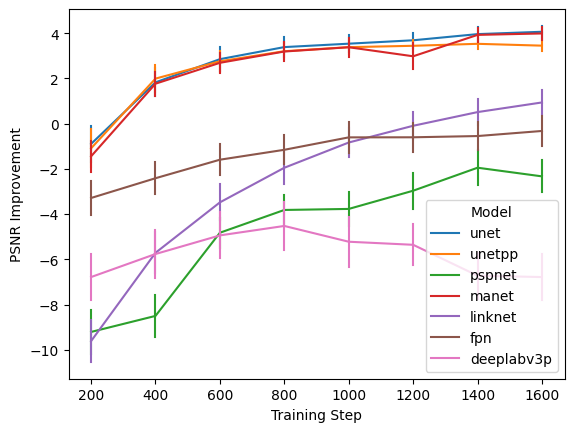

In [66]:
sns.lineplot(data=df_step, x="Training Step", y="PSNR Improvement", hue="Model",err_style="bars", errorbar=("se", 0.5))